## My Notebook


In [210]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [249]:
#train data
data = pd.read_csv('../raw_data/dengue_features_train.csv')
labels = pd.read_csv('../raw_data/dengue_labels_train.csv')
data = data.merge(labels)
print(data.shape)

#test data
test_data = pd.read_csv('../raw_data/dengue_features_test.csv')
print(test_data.shape)

(1456, 25)
(416, 24)


In [250]:
data

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


## Basic data preparation and visualizations

In [251]:
corr_df= corr.stack().reset_index() # Unstack correlation matrix
corr_df.columns= ['feature_1','feature_2', 'correlation']# rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True)# sort by correlation
corr_df= corr_df[corr_df['feature_1']!= corr_df['feature_2']]# Remove self correlation
corr_df


,feature_1,feature_2,correlation
152,precipitation_amt_mm,reanalysis_sat_precip_amt_mm,1.000000
328,reanalysis_sat_precip_amt_mm,precipitation_amt_mm,1.000000
354,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,0.997051
222,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,0.997051
378,reanalysis_tdtr_k,reanalysis_max_air_temp_k,0.918578
...,...,...,...
57,ndvi_ne,reanalysis_min_air_temp_k,-0.623116
271,reanalysis_min_air_temp_k,station_diur_temp_rng_c,-0.715676
425,station_diur_temp_rng_c,reanalysis_min_air_temp_k,-0.715676
269,reanalysis_min_air_temp_k,reanalysis_tdtr_k,-0.815511


In [252]:
#NaN count for each column
data.isnull().sum().sort_values(ascending=False)

ndvi_ne                                  194
ndvi_nw                                   52
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_precip_mm                         22
ndvi_se                                   22
ndvi_sw                                   22
station_max_temp_c                        20
station_min_temp_c                        14
precipitation_amt_mm                      13
reanalysis_sat_precip_amt_mm              13
reanalysis_relative_humidity_percent      10
reanalysis_tdtr_k                         10
reanalysis_specific_humidity_g_per_kg     10
reanalysis_max_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_min_air_temp_k                 10
reanalysis_dew_point_temp_k               10
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
city                                       0
year                                       0
week_start

In [253]:
data_sj = data.iloc[:936,:]

In [254]:
data_iq = data.iloc[936:,:]

In [255]:
print(data_iq.shape,data_sj.shape)

(520, 25) (936, 25)


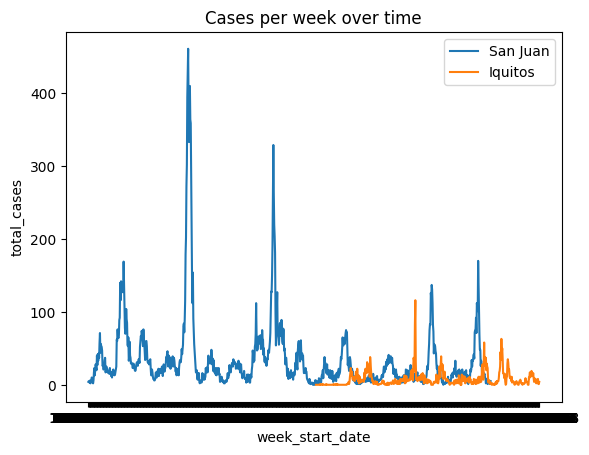

In [256]:
plt.title('Cases per week over time')
sns.lineplot(data=data_sj,x='week_start_date',y='total_cases',label='San Juan')
sns.lineplot(data=data_iq,x='week_start_date',y='total_cases',label='Iquitos')
plt.legend()
plt.show;

## Preprocessing San Juan

In [257]:
from sklearn.preprocessing import MinMaxScaler

In [287]:
def preprocess_sj(rawfeats, train=True):
    
    #fill nas with interpolation
    feats = rawfeats.interpolate(method='linear')
    
    #scale then average temperature readings 
    tempscols_to_average = feats.loc[:,['reanalysis_max_air_temp_k', 'station_avg_temp_c',
       'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_dew_point_temp_k',
       'reanalysis_air_temp_k']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(tempscols_to_average), 
                            columns=tempscols_to_average.columns)
    feats.loc[:,'temps_mean'] = scaled_temps.mean(axis=1)
    
    #add shifted features, 3 weeks
    to_shift = ['station_max_temp_c', 'temps_mean','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2'] 
    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)
        feats[i+'_3lag'] = feats[i].shift(-3)
    feats = feats.fillna(method='ffill')
    
    #fix time data
    feats['Year_Week'] = pd.to_datetime(rawfeats['week_start_date']).dt.strftime('%Y-%U')
    feats['Week'] = pd.to_datetime(rawfeats['week_start_date']).dt.strftime('%U')
    feats['month'] = pd.DatetimeIndex(rawfeats['week_start_date']).month
    
    #drop columns
    feats.drop(columns=['reanalysis_max_air_temp_k', 'station_avg_temp_c',
       'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_dew_point_temp_k',
       'reanalysis_air_temp_k','city','week_start_date','weekofyear','year'],inplace=True)
    
    return feats

In [288]:
sj_data = preprocess_sj(data_sj)

In [289]:
sj_data.iloc[150:200]

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,...,reanalysis_relative_humidity_percent_3lag,reanalysis_specific_humidity_g_per_kg_1lag,reanalysis_specific_humidity_g_per_kg_2lag,reanalysis_specific_humidity_g_per_kg_3lag,reanalysis_precip_amt_kg_per_m2_1lag,reanalysis_precip_amt_kg_per_m2_2lag,reanalysis_precip_amt_kg_per_m2_3lag,Year_Week,Week,month
150,-0.041100,-0.043600,0.172533,0.171771,9.68,10.50,77.784286,9.68,15.064286,2.685714,...,78.564286,14.648571,15.200000,15.162857,13.00,20.27,14.20,1993-11,11,3
151,0.032250,0.103150,0.185014,0.204186,27.00,13.00,76.848571,27.00,14.648571,2.257143,...,78.961429,15.200000,15.162857,15.500000,20.27,14.20,23.20,1993-12,12,3
152,0.119400,0.088533,0.140471,0.117429,0.00,20.27,80.795714,0.00,15.200000,2.142857,...,81.271429,15.162857,15.500000,15.488571,14.20,23.20,63.49,1993-13,13,4
153,0.051800,0.042300,0.190367,0.208214,7.49,14.20,78.564286,7.49,15.162857,2.357143,...,81.655714,15.500000,15.488571,16.597143,23.20,63.49,34.30,1993-14,14,4
154,-0.015800,0.018850,0.068000,0.083400,19.74,23.20,78.961429,19.74,15.500000,3.057143,...,84.081429,15.488571,16.597143,16.658571,63.49,34.30,40.70,1993-15,15,4
155,0.082800,0.078800,0.133457,0.131700,114.85,63.49,81.271429,114.85,15.488571,2.771429,...,84.521429,16.597143,16.658571,16.267143,34.30,40.70,142.40,1993-16,16,4
156,0.081225,0.092567,0.131517,0.125229,33.35,34.30,81.655714,33.35,16.597143,2.471429,...,82.435714,16.658571,16.267143,16.857143,40.70,142.40,55.67,1993-17,17,4
157,0.079650,0.064150,0.154743,0.129157,37.35,40.70,84.081429,37.35,16.658571,1.857143,...,85.398571,16.267143,16.857143,18.185714,142.40,55.67,100.20,1993-18,18,5
158,0.073050,0.052000,0.107486,0.107029,34.90,142.40,84.521429,34.90,16.267143,2.500000,...,86.900000,16.857143,18.185714,17.951429,55.67,100.20,93.20,1993-19,19,5
159,0.176900,0.090100,0.179200,0.186683,14.84,55.67,82.435714,14.84,16.857143,2.214286,...,80.615714,18.185714,17.951429,18.491429,100.20,93.20,20.20,1993-20,20,5


In [103]:
# Remove `week_start_date` string.
data_sj.drop(columns=['week_start_date','weekofyear','year','city'], axis=1, inplace=True)
data_iq.drop(columns=['week_start_date','weekofyear','year','city'], axis=1, inplace=True)

/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_94107/3649832353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sj.drop(columns=['week_start_date','weekofyear','year','city'], axis=1, inplace=True)
/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_94107/3649832353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_iq.drop(columns=['week_start_date','weekofyear','year','city'], axis=1, inplace=True)


In [104]:
data_sj

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,294.4,...,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4
932,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,296.5,...,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3
933,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,295.8,...,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1
934,0.001800,-0.052750,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,299.7,295.9,...,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3


In [105]:
# compute the correlations
sj_correlations = data_sj.corr()
iq_correlations = data_iq.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

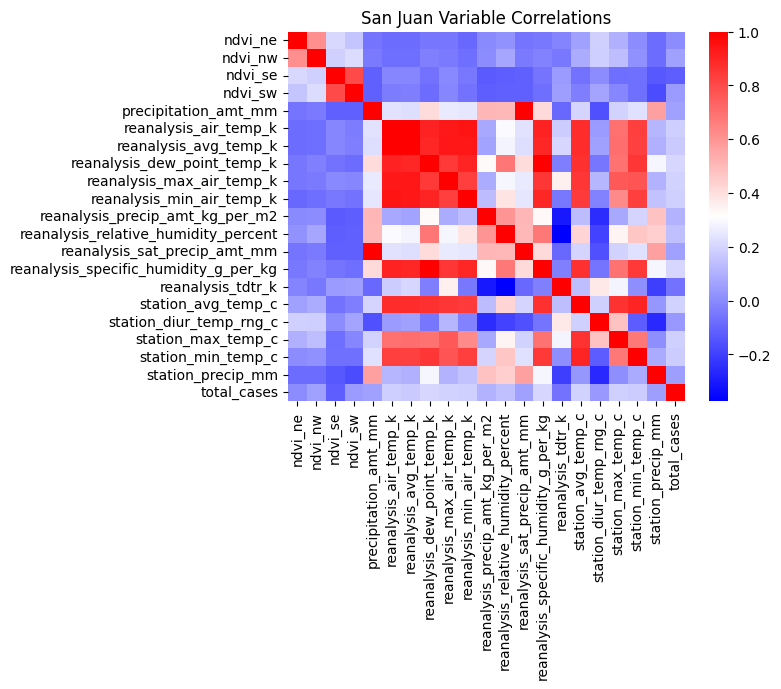

In [106]:
# plot san juan
sj_heatmap = sns.heatmap(sj_correlations,cmap= "bwr")
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

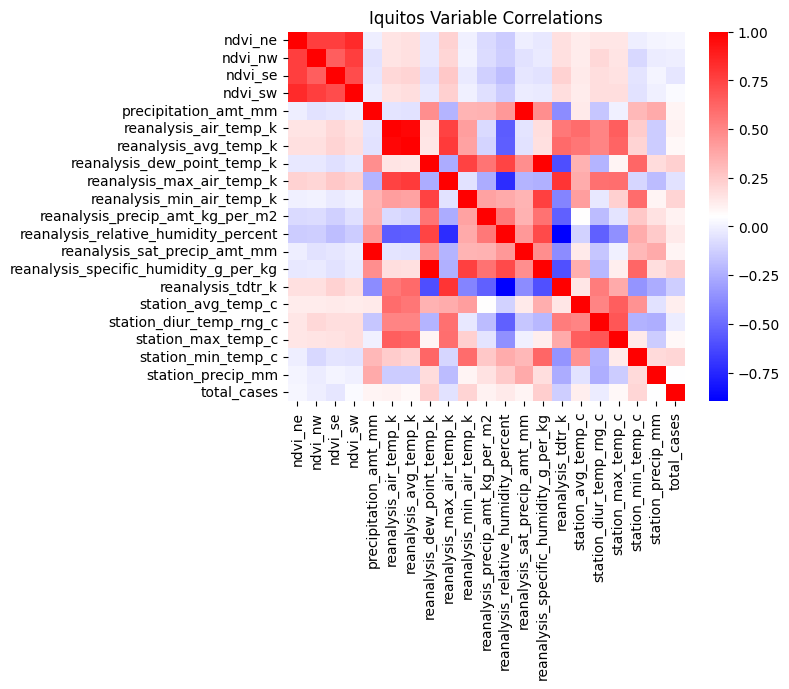

In [107]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations,cmap= "bwr")
plt.title('Iquitos Variable Correlations')

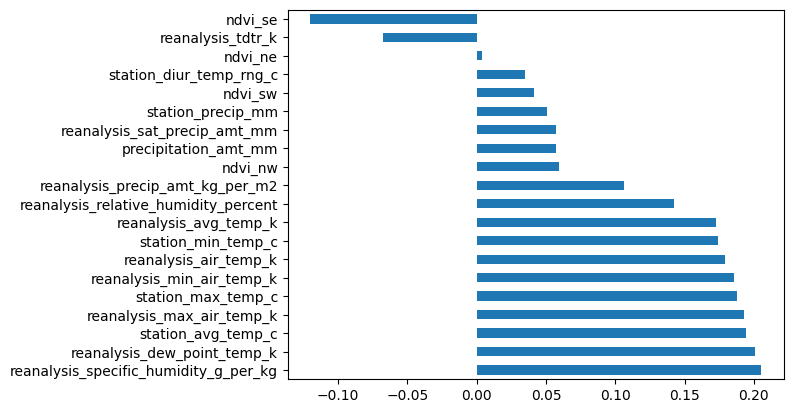

In [108]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh());

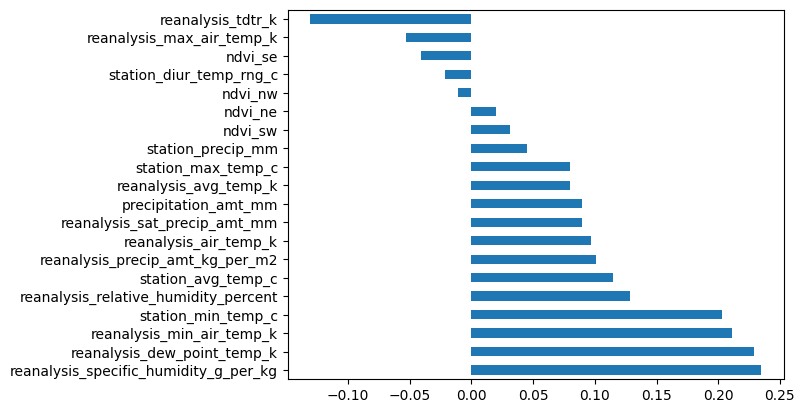

In [109]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh());

In [121]:
sj_train = data_sj.head(800)
sj_test = data_sj.tail(136)

iq_train = data_iq.head(400)
iq_test = data_iq.tail(120)

In [132]:
from statsmodels.tsa.stattools import adfuller

print('p-value: ', adfuller(data_sj["total_cases"])[1])

p-value:  5.1473186737591e-09


In [135]:
from statsmodels.tsa.stattools import adfuller

print('p-value: ', adfuller(data_iq["total_cases"])[1])

p-value:  1.0672522948401663e-07


/Users/OscarSchrankler/.pyenv/versions/3.10.6/envs/dengue_fever/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


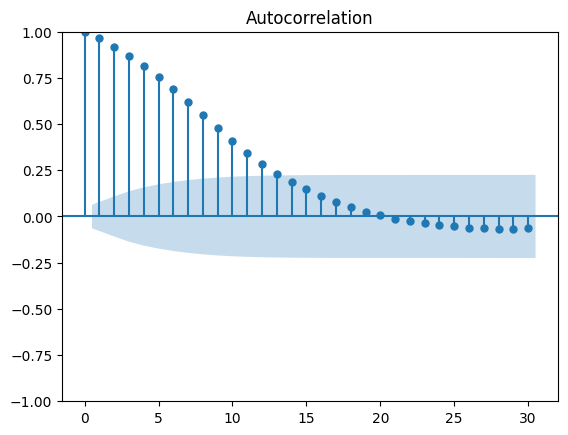

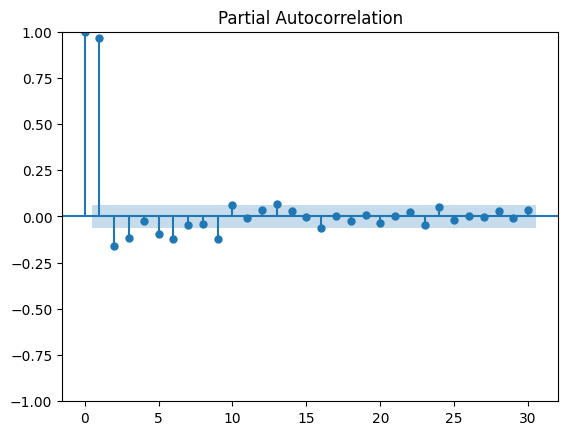

In [140]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y_sj = data_sj["total_cases"]
y_iq = data_iq["total_cases"]
plot_acf(y_sj);
plot_pacf(y_sj);

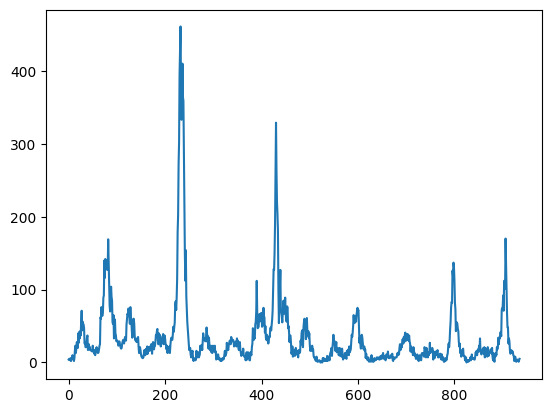

In [146]:
plt.plot(y_sj)